# TLDR

Todo:
- We run [ethnicolr](https://github.com/appeler/ethnicolr) race models using the names of employees in Florida Public Payroll (university, state, city, school teachers, county) to estimate the race composition of these institutions.

- No non-white race group in (university, state, city, school teachers, county) except for Asian/University outperform the state average of that race.

- Comparing the census of [2010](https://en.wikipedia.org/wiki/Demographics_of_Florida) and [2000](https://www.census.gov/prod/2002pubs/c2kprof00-fl.pdf),  White-Not Hispanic race proportion dropped from 60% to 53.5%, 11% drop in 10 years.  The white-not hispanic race proportion in (university, state, city, school teachers, county) have only dropped 4-6% in the years spanning longer than that time period.

- If we estimate the average salary by each race, white-not hispanic race has the highest salary for school teachers.  

In [2]:
from ethnicolr import census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name
import pandas as pd
from os import listdir
from os.path import isfile, join



Using TensorFlow backend.


## Create Imputed Race Dataset

In [ ]:
import pandas as pd
from ethnicolr import census_ln, pred_census_ln, pred_wiki_ln, pred_wiki_name, pred_fl_reg_ln, pred_fl_reg_name


path = os.getcwd()
path = path.replace('notebook', 'data/')

race_summary_not_wiki = pd.DataFrame()
race_summary_wiki = pd.DataFrame()
models = ['race_census_ln', 'race_pred_census_ln', 'race_pred_fl_reg_ln', 'race_pred_fl_reg_name']
onlyfiles=['state_1995_2014.csv', 'k12_1997_2014.csv', 'counties_1995_2014.csv', 'cities_1995_2014.csv', 'university_2014.csv',]

for f in onlyfiles:
    df_org = pd.read_csv(path+f)
    df = df_org.drop_duplicates(subset=['Employee Name'])
    df = df[['Employee Name']]
    
    df['ln'] = df['Employee Name'].str.split(',').str[0].str.lower()
    df['fn'] = df['Employee Name'].str.split(',').str[1].str.split(' ').str[1].str.strip()
    original_columns = list(df.columns)
    
    models_str = []
    for model in [census_ln, pred_census_ln, pred_fl_reg_ln, pred_fl_reg_name]:
        model_name = model.__name__
        models_str.append('race_'+model_name)
        if(model_name=='census_ln'): 
            df = model(df, 'ln')
            df.replace('(S)', '0', inplace=True)
            race_cols = df.columns[df.columns.str.startswith('pct')]
            for col in race_cols:
                df[col] = df[col].astype('double')
            df['race'] = df[race_cols].idxmax(axis=1)
        elif(model_name=='pred_wiki_name'):
            df = model(df, 'fn', 'ln')
        elif(model_name=='pred_fl_reg_name'):
            df = model(df, lname_col='ln', fname_col='fn')
        else:
            df = model(df, 'ln')
        
        df.rename(columns={'race':'race_'+model_name}, inplace=True) 
    
    df_org = df_org.merge(df, how='left', on=['Employee Name'])
    df_org.to_csv(root+'employee_race/data/'+f)
    print('done:', f)
    
#############################################################################

onlyfiles=['state_1995_2014.csv', 'k12_1997_2014.csv', 'counties_1995_2014.csv', 'cities_1995_2014.csv', 'university_2014.csv',]

for f in onlyfiles:
    df = pd.read_csv(root+'employee_race/data/'+f, index_col=[0])
    start_ind = pd.DataFrame(df.dtypes).reset_index()
    temp = start_ind.loc[start_ind['index']=='ln'].index[0]
    
    keep_cols1 = list(start_ind.loc[:temp-1, 'index'])
    keep_cols2 = list(df.columns[df.columns.str.startswith('race')])
    df2 = df[keep_cols1+keep_cols2]
    df2.to_csv(root+'employee_race/data/'+f.replace('.csv', '_all.csv'))



#############################################################################



### Produces the csv files that have grouped salary and race composition over years

In [ ]:
def get_stats(df, df_description, name, year_begin=2014, year_end=2014, race='all', model='n/a'):
    print(name, year_begin, year_end, race, model)
    counter = df_description.shape[0]
    skip = 1
    try:
        df_prev = df_description.loc[
                (df_description.gov == name)&
                (df_description.year_period_start==year_begin)&
                (df_description.year_period_end==year_end)&(df_description.model=='n/a')].drop_duplicates(keep='last')
        
        n_observations = df_prev['n_observations'].values[0]
        n_uniq = df_prev['n_uniq_observations'].values[0]
        avg_salary = df_prev['salary_avg'].values[0]
        median_salary = df_prev['salary_median'].values[0]
        uniq_avg_salary = df_prev['uniq_salary_avg'].values[0]
        uniq_median_salary = df_prev['uniq_salary_median'].values[0]
    except:
        print('errror')
        skip = 0
        
    df_uniq = df.drop_duplicates(subset=['Employee Name'])
    df_description.loc[counter, 'gov'] = name
    df_description.loc[counter, 'year_period_start'] = year_begin
    df_description.loc[counter, 'year_period_end'] = year_end
    df_description.loc[counter, 'state'] = 'fl'
    df_description.loc[counter, 'race'] = race
    df_description.loc[counter, 'model'] = model

    df_description.loc[counter, 'n_observations'] = df.shape[0]  
    df_description.loc[counter, 'salary_avg'] = df[pay].mean()/1e3    
    df_description.loc[counter, 'salary_median'] = df[pay].median()/1e3
    df_description.loc[counter, 'salary_min'] = df[pay].min()/1e3
    df_description.loc[counter, 'salary_max'] = df[pay].max()/1e3
    df_description.loc[counter, 'salary_std'] = df[pay].std()/1e3   
    
    df_description.loc[counter, 'n_uniq_observations'] = df_uniq.shape[0]  
    df_description.loc[counter, 'uniq_salary_avg'] = df_uniq[pay].mean()/1e3    
    df_description.loc[counter, 'uniq_salary_median'] = df_uniq[pay].median()/1e3
    df_description.loc[counter, 'uniq_salary_min'] = df_uniq[pay].min()/1e3
    df_description.loc[counter, 'uniq_salary_max'] = df_uniq[pay].max()/1e3
    df_description.loc[counter, 'uniq_salary_std'] = df_uniq[pay].std()/1e3  
    
    if(skip>0):
        df_description.loc[counter, 'race_composition'] = df.shape[0]/n_observations
        df_description.loc[counter, 'race_composition_uniq'] = df_uniq.shape[0]/n_uniq
      
        df_description.loc[counter, 'ratio_avgRaceSalary_avgPopSalary'
                           ] =  df_description.loc[counter, 'salary_avg']/avg_salary 
        df_description.loc[counter, 'uniq_ratio_avgRaceSalary_avgPopSalary'
                           ] =  df_description.loc[counter, 'uniq_salary_avg']/uniq_avg_salary 
                           
        df_description.loc[counter, 'ratio_medianRaceSalary_medianPopSalary'
                           ] =  df_description.loc[counter, 'salary_median']/median_salary 
        df_description.loc[counter, 'uniq_ratio_medianRaceSalary_medianPopSalary'
                           ] =  df_description.loc[counter, 'uniq_salary_median']/uniq_median_salary 
    return df_description

    
 
pay_map = {'state':'Total Compensation', 'cities':'Salary', 'k12':'Salary', 'counties':'Salary', 'university':'Annual Salary'}
onlyfiles=['university_2014.csv', 'state_1995_2014_all.csv', 'k12_1997_2014_all.csv',
           'counties_1995_2014_all.csv', 'cities_1995_2014_all.csv']
models = ['race_census_ln', 'race_pred_census_ln', 'race_pred_fl_reg_ln', 'race_pred_fl_reg_name']

df_description = pd.DataFrame()
for f in onlyfiles:
    df = pd.read_csv(root+'employee_race/data/'+f)
    name = f.split('_')[0]
    pay = pay_map[name]
    year_def1 = f.split('_')[1].replace('.csv', '')
    try:
        year_def2 = f.split('_')[2].replace('.csv', '')
    except:
        year_def2 = year_def1
        
    if(df[pay].dtype=='O'):
        df[pay] = df[pay].str.replace('$', '')
        df[pay] = df[pay].str.replace(',', '')
        df[pay] = df[pay].astype('double')
    df = df.loc[df[pay]>0]
    get_stats(df, df_description, name, year_begin=year_def1, year_end=year_def2)
    
    for model in models:
        for race in ['white', 'hispanic', 'black', 'asian']:
            if(race=='asian'):    
                df_race = df.loc[(df[model].str.contains(race))|(df[model].str.contains('api'))]
            else:
                df_race = df.loc[(df[model].str.contains(race))&~(pd.isna(df[model]))]           
            get_stats(df_race, df_description, name, race=race, model=model,
                      year_begin=year_def1, year_end=year_def2)
            
            
    if('Year' in df.columns):
        for year in df.Year.unique():
            df_year = df.loc[df.Year==year]
            get_stats(df_year, df_description, name, year_begin=year, year_end=year)
            for model in models:
                for race in ['white', 'hispanic', 'black', 'asian']:
                    if(race=='asian'):    
                        df_race = df_year.loc[(df_year[model].str.contains(race))|(df_year[model].str.contains('api'))]
                    else:
                        df_race = df_year.loc[(df_year[model].str.contains(race))&~(pd.isna(df_year[model]))]           
                    get_stats(df_race, df_description, name, race=race, model=model,
                              year_begin=year, year_end=year)
         
    
df_description.to_csv(root+'employee_race/data/florida_stats.csv')


In [ ]:
df_description.sort_values(by=['gov', 'year'], inplace=True)
df_description.head()

## Race Composition Plot

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os


df_description = pd.read_csv('../data/florida_stats.csv')

df_all = df_description.drop_duplicates(['gov', 'race', 'model'])
df_all_gb = df_all.groupby(['gov', 'race']).mean()[['race_composition',
                          'race_composition_uniq']].reset_index()
df_all_gb.rename(columns={'gov':'institution'}, inplace=True)

asian = df_all_gb.loc[df_all_gb.race=='asian'].sort_values(by='institution')
hispanic = df_all_gb.loc[df_all_gb.race=='hispanic'].sort_values(by='institution')
black = df_all_gb.loc[df_all_gb.race=='black'].sort_values(by='institution')
white = df_all_gb.loc[df_all_gb.race=='white'].sort_values(by='institution')

state_white = .535
state_white = .773
state_black = .169
state_asian = .03
state_hispanic = .261


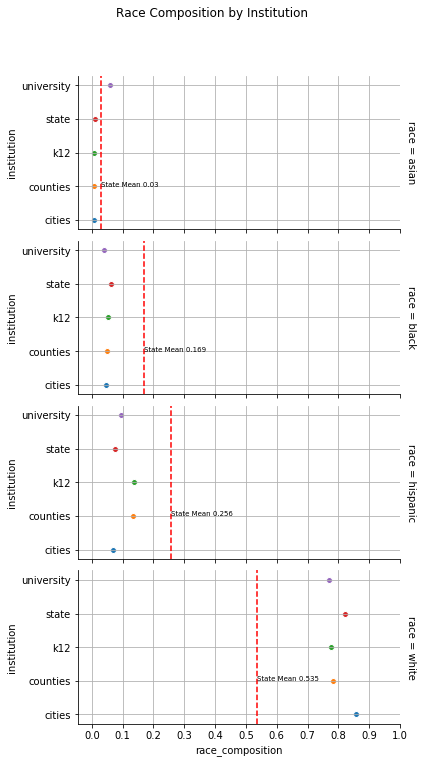

In [4]:

plt.close('all')
g = sns.FacetGrid(df_all_gb.loc[df_all_gb.race!='all'], row="race",  hue="institution", margin_titles=True, aspect=2)
g = (g.map(plt.scatter,  "race_composition","institution", edgecolor="w"))
g = g.set(xticks = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.0])
#g.set(xticks=df.a[2::8])

statemeans = [.03,.169,.256,.535]
race = ['Asian', 'Black', 'Hispanic', 'White-Not Hispanic']
for i, a in enumerate(g.axes):
    a[0].grid()
    a[0].axvline(statemeans[i], ls='--', color='red')
    a[0].text(statemeans[i],1, "State Mean "+str(statemeans[i]), fontsize=7)

    
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Race Composition by Institution') 
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('../paper/Figures/race_composition_across_inst.png')



## Salary Comparison by Race

In [15]:

df_all['total_salary'] = df_all.n_observations * df_all.salary_avg

df_all_pay_gb = df_all.groupby(['gov', 'race']).sum()[['total_salary',
                          'n_observations']].reset_index()

df_all_pay_gb['avg_salary'] = df_all_pay_gb['total_salary']/df_all_pay_gb['n_observations']

df_all_pay_gb_median = df_all.groupby(['gov', 'race']).mean()[['salary_median']].reset_index()

asian_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='asian'].sort_values(by='gov')
hispanic_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='hispanic'].sort_values(by='gov')
black_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='black'].sort_values(by='gov')
white_pay = df_all_pay_gb.loc[df_all_pay_gb.race=='white'].sort_values(by='gov')

df_all_pay_gb_median


/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,gov,race,salary_median
0,cities,all,29.408930
1,cities,asian,35.080595
2,cities,black,25.536267
3,cities,hispanic,30.807481
4,cities,white,29.466094
5,counties,all,35.635055
6,counties,asian,39.914530
7,counties,black,34.175910
8,counties,hispanic,38.393574
9,counties,white,35.258331


### Race/Salary/Institution

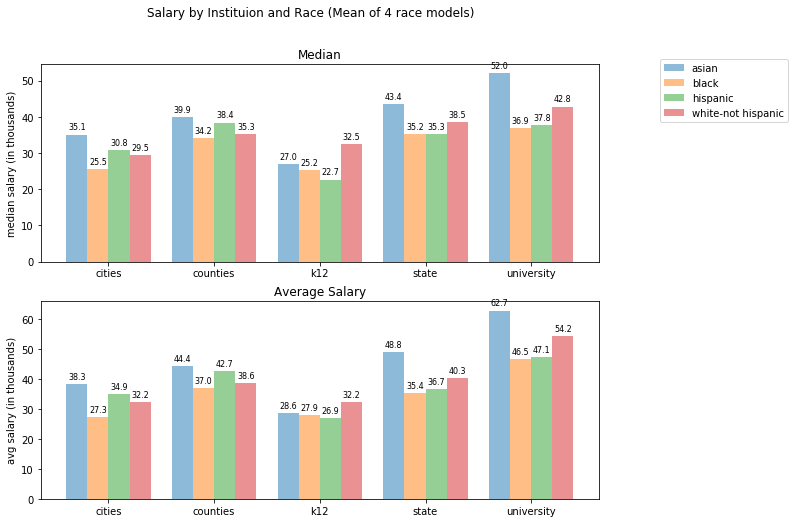

In [20]:
def autolabel(rects, axis):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax[axis].annotate('{}'.format(round(height,1)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

x = np.arange(5)  
width = 0.20
margin = 0.05

# Race Pay
##############################################################
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(10, 8))    
rect_asian = ax[0].bar(x - .3, df_all_pay_gb_median.loc[df_all_pay_gb.race=='asian', 'salary_median'],
          width, label='asian', alpha=.5)
rect_black = ax[0].bar(x - .1, df_all_pay_gb_median.loc[df_all_pay_gb.race=='black', 'salary_median'],
          width, label='black', alpha=.5)
rect_hispanic = ax[0].bar(x + .1, df_all_pay_gb_median.loc[df_all_pay_gb.race=='hispanic', 'salary_median'],
          width, label='hispanic', alpha=.5)
rect_white = ax[0].bar(x + .3, df_all_pay_gb_median.loc[df_all_pay_gb.race=='white', 'salary_median'],
          width, label='white-not hispanic', alpha=.5)
ax[0].set_ylabel('median salary (in thousands)')
ax[0].set_title('Median')
ax[0].set_xticks(x)
ax[0].set_xticklabels(asian.institution)
ax[0].legend(bbox_to_anchor=(1.1, 1.05))

autolabel(rect_asian,0)
autolabel(rect_black,0)
autolabel(rect_hispanic,0)
autolabel(rect_white,0)

rect_asian = ax[1].bar(x - .3, asian_pay.avg_salary, width, label='asian', alpha=.5)
rect_black = ax[1].bar(x - .1, black_pay.avg_salary, width, label='black', alpha=.5)
rect_hispanic = ax[1].bar(x + .1, hispanic_pay.avg_salary, width, label='hispanic', alpha=.5)
rect_white = ax[1].bar(x + .3, white_pay.avg_salary, width, label='white', alpha=.5)
ax[1].set_ylabel('avg salary (in thousands)')
ax[1].set_title('Average Salary')
ax[1].set_xticks(x)
ax[1].set_xticklabels(asian.institution)
ax[0].legend(bbox_to_anchor=(1.1, 1.05))

autolabel(rect_asian,1)
autolabel(rect_black,1)
autolabel(rect_hispanic,1)
autolabel(rect_white,1)

plt.suptitle('Salary by Instituion and Race (Mean of 4 race models)')
plt.savefig('../paper/Figures/race_median_pay.png')


##############################################################



In [21]:
df_years = df_description.loc[df_description.year_period_start == df_description.year_period_end]
df_year_gb = df_years.groupby(['year_period_start', 'gov', 'race']).mean()[['race_composition',
                          'race_composition_uniq']].reset_index()
df_year_gb = df_year_gb.loc[df_year_gb.gov!='university']
df_year_gb['year'] = df_year_gb['year_period_start'].astype('int')
df_year_gb['log_composition'] = np.log(df_year_gb.race_composition)

asian = df_year_gb.loc[df_year_gb.race=='asian'].sort_values(by=['race', 'gov', 'year_period_start'])
hispanic = df_year_gb.loc[df_year_gb.race=='hispanic'].sort_values(by=['race', 'gov', 'year_period_start'])
black = df_year_gb.loc[df_year_gb.race=='black'].sort_values(by=['race', 'gov', 'year_period_start'])
white = df_year_gb.loc[df_year_gb.race=='white'].sort_values(by=['race', 'gov', 'year_period_start'])




### Race Composition Time Series (1994-2014)

In [22]:
asian.dtypes

year_period_start          int64
gov                       object
race                      object
race_composition         float64
race_composition_uniq    float64
year                       int64
log_composition          float64
dtype: object

In [31]:
from  matplotlib.ticker import MaxNLocator

def plot_series(df_array, plot_col, titles, sup_title, xlabel=None, ylabel=None, xinteger=False, grid=False):
    plt.close('all')

    fig, ax = plt.subplots(4, 1, figsize=(15, 15), sharex=True)    
    for i in range(len(df_array)):
        temp = df_array[i]
        ax[i].plot(temp.loc[temp.gov=='state', 'year'], temp.loc[temp.gov=='state', plot_col], label='state')
        ax[i].plot(temp.loc[temp.gov=='k12', 'year'], temp.loc[temp.gov=='k12', plot_col], label='k12')
        ax[i].plot(temp.loc[temp.gov=='counties', 'year'], temp.loc[temp.gov=='counties', plot_col], label='counties')
        ax[i].plot(temp.loc[temp.gov=='cities', 'year'], temp.loc[temp.gov=='cities', plot_col], label='cities')
        if(ylabel!=None):
            ax[i].set_ylabel(ylabel)
        if(xlabel!=None):
            ax[i].set_xlabel(xlabel)
        ax[i].set_title(titles[i])
        if(grid==True):
            ax[i].grid()
        if(i==0):
            ax[i].legend(loc='best')
        if((i==len(df_array)-1)&(xinteger==True)):
            ax[2].xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.suptitle(sup_title)
    plt.savefig('../paper/Figures/'+plot_col+'_ts.png')



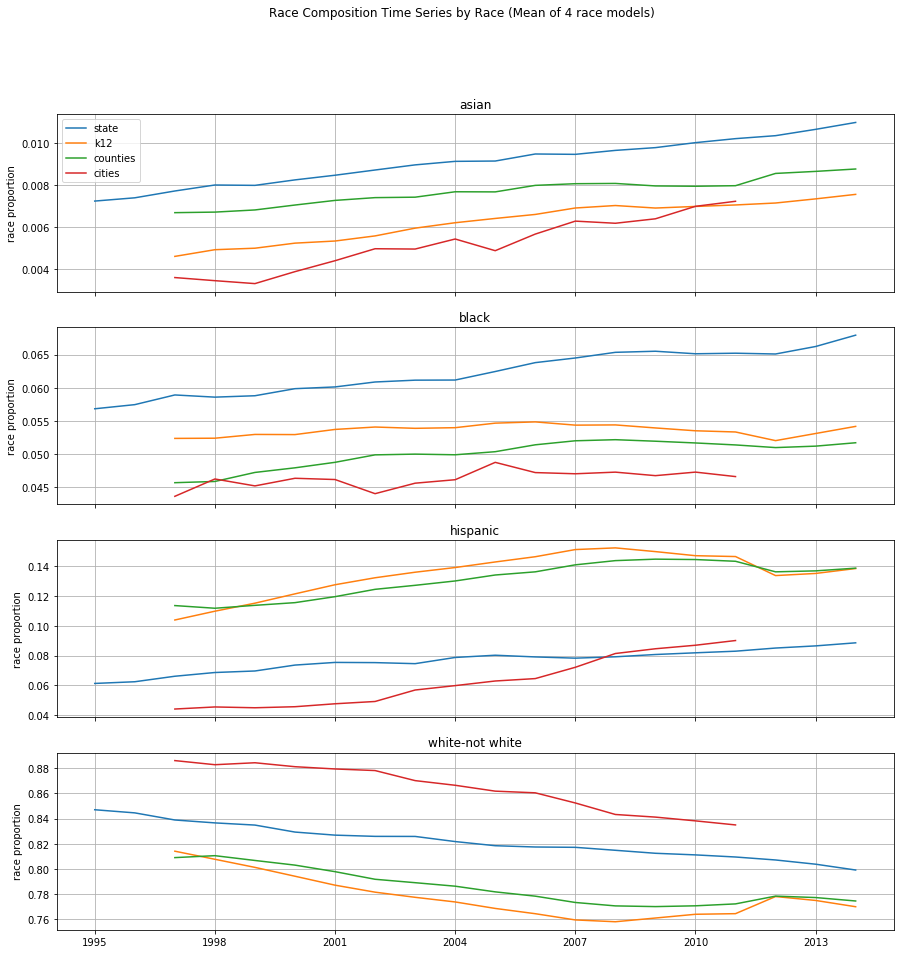

In [26]:
plot_series([asian, black, hispanic, white], 'race_composition', ['asian', 'black', 'hispanic', 'white-not white'], 'Race Composition Time Series by Race (Mean of 4 race models)', xlabel=None, ylabel='race proportion', xinteger=True, grid=True)

### Race/Pay Time Series (1994-2014)


In [32]:
df_years['total_salary'] = df_years.n_observations * df_years.salary_avg
df_years_pay_gb = df_years.groupby(['year_period_start', 'gov', 'race']).sum()[['total_salary',
                          'n_observations']].reset_index()
df_years_pay_gb['year'] = df_years_pay_gb['year_period_start'].astype('int')
df_years_pay_gb['avg_salary'] = df_years_pay_gb['total_salary']/df_years_pay_gb['n_observations']

asian = df_years_pay_gb.loc[df_years_pay_gb.race=='asian'].sort_values(by=['gov', 'year'])
hispanic = df_years_pay_gb.loc[df_years_pay_gb.race=='hispanic'].sort_values(by=['gov', 'year'])
black = df_years_pay_gb.loc[df_years_pay_gb.race=='black'].sort_values(by=['gov', 'year'])
white = df_years_pay_gb.loc[df_years_pay_gb.race=='white'].sort_values(by=['gov', 'year'])
population = df_years_pay_gb.loc[df_years_pay_gb.race=='all'].sort_values(by=['gov', 'year'])

df_years_pay_gb_median = df_years.groupby(['year_period_start', 'gov', 'race']).mean()[['salary_median']].reset_index()



/Users/seunglee/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
df_years_pay_gb_median

,year_period_start,gov,race,salary_median
0,1995,state,all,26.637990
1,1995,state,asian,29.055222
2,1995,state,black,24.269390
3,1995,state,hispanic,24.352605
4,1995,state,white,26.854291
5,1996,state,all,28.155730
6,1996,state,asian,31.197061
7,1996,state,black,25.799163
8,1996,state,hispanic,26.180379
9,1996,state,white,28.421100


In [28]:
df_years_pay_gb_median.rename(columns={'year_period_start':'year', 'salary_median':'median_salary'}, inplace=True)
asian_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='asian']
black_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='black']
hispanic_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='hispanic']
white_med = df_years_pay_gb_median.loc[df_years_pay_gb_median.race=='white']


Median Salary TS

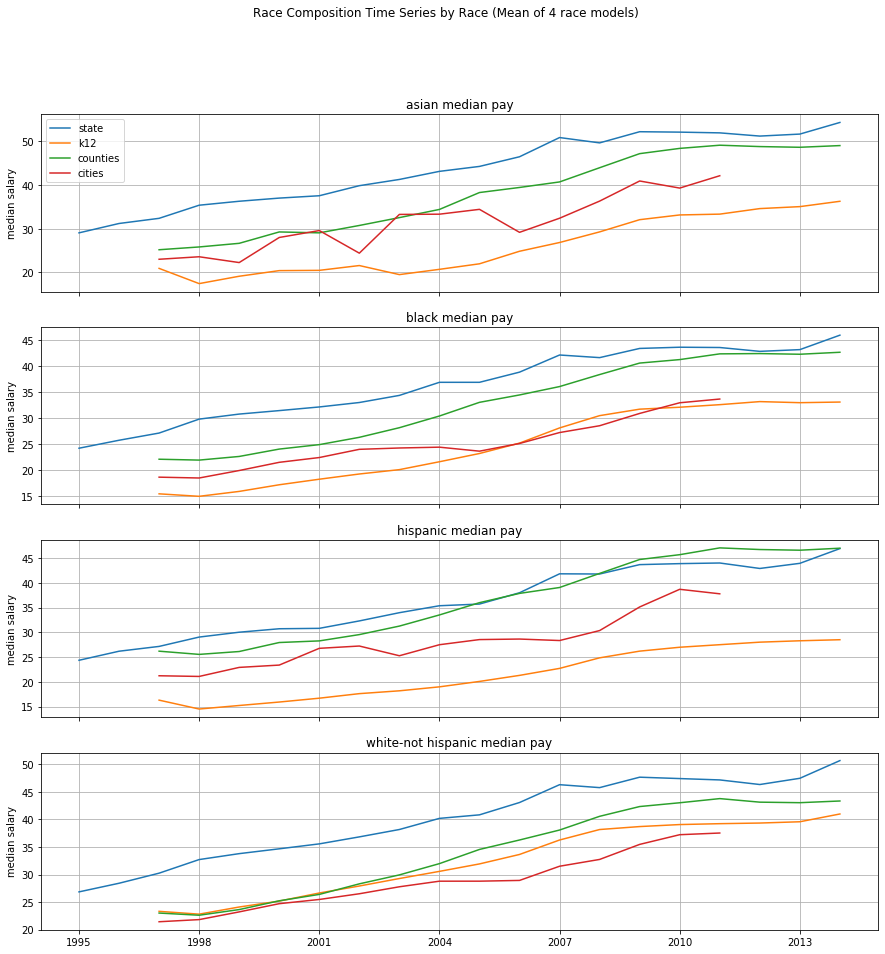

In [33]:
plot_series([asian_med, black_med, hispanic_med, white_med], 'median_salary', ['asian median pay', 'black median pay', 'hispanic median pay', 'white-not hispanic median pay'], 'Race Composition Time Series by Race (Mean of 4 race models)', xlabel=None, ylabel='median salary', xinteger=True, grid=True)

Average Salary Time Series

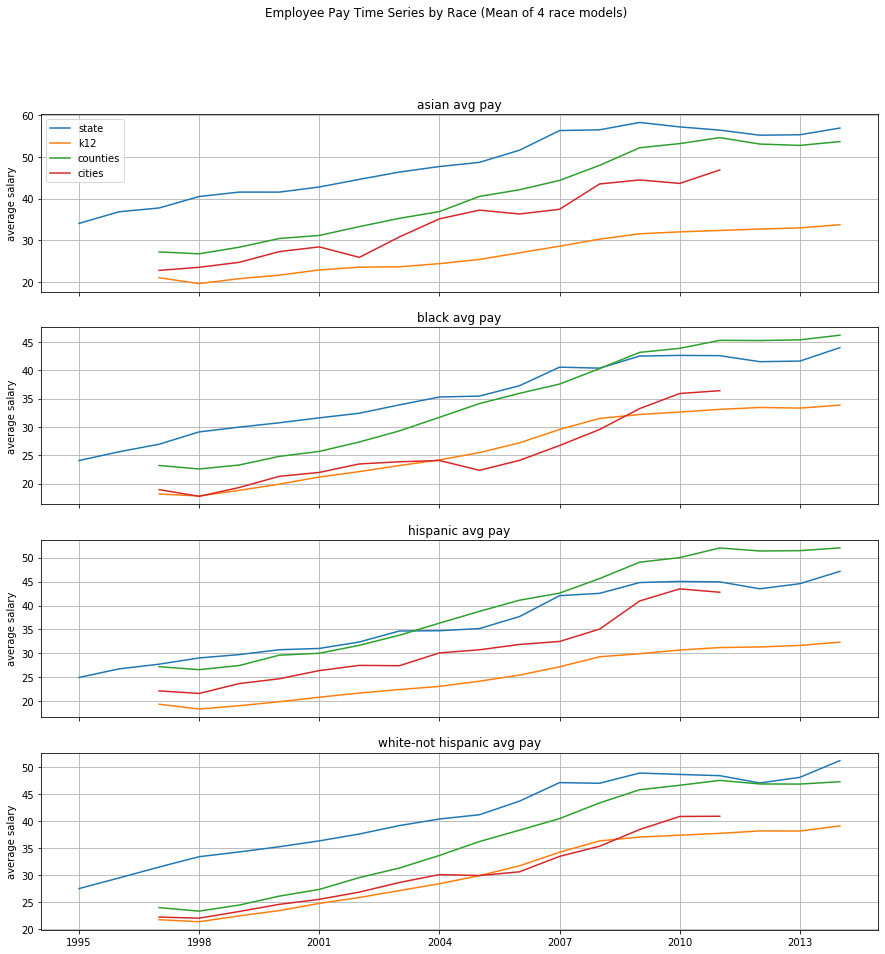

In [30]:
plot_series([asian, black, hispanic, white], 'avg_salary', ['asian avg pay', 'black avg pay', 'hispanic avg pay', 'white-not hispanic avg pay'], 'Employee Pay Time Series by Race (Mean of 4 race models)', xlabel=None, ylabel='average salary', xinteger=True, grid=True)





State mean from 2010 census.
https://en.wikipedia.org/wiki/Demographics_of_Florida